Implement a simple Generative Adversarial Network (GAN) to generate synthetic images similar to MNIST digits. Learn how to build Generator and Discriminator, and train them adversarially.

In [ ]:
#1. Imports & Data
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]


In [ ]:
# 2. Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()  # output between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

In [ ]:
# 3. Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 784))

In [ ]:
# 4. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# 5. Training Loop
epochs = 50
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        output_real = discriminator(real_imgs)
        loss_real = criterion(output_real, real)

        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = generator(z)
        output_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        output_fake = discriminator(fake_imgs)
        loss_G = criterion(output_fake, real)  # want D to think fakes are real
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch [1/50] Loss D: 0.3220, Loss G: 3.0025
Epoch [2/50] Loss D: 0.2372, Loss G: 2.5880
Epoch [3/50] Loss D: 0.3142, Loss G: 4.7652
Epoch [4/50] Loss D: 0.3134, Loss G: 3.5784
Epoch [5/50] Loss D: 1.3131, Loss G: 2.0722
Epoch [6/50] Loss D: 0.5392, Loss G: 2.7409
Epoch [7/50] Loss D: 0.4324, Loss G: 3.0698
Epoch [8/50] Loss D: 0.7020, Loss G: 2.6461
Epoch [9/50] Loss D: 0.4824, Loss G: 2.1513
Epoch [10/50] Loss D: 0.3329, Loss G: 2.4834
Epoch [11/50] Loss D: 0.7662, Loss G: 2.4892
Epoch [12/50] Loss D: 0.6960, Loss G: 2.0781
Epoch [13/50] Loss D: 0.7590, Loss G: 2.2015
Epoch [14/50] Loss D: 0.6505, Loss G: 1.8463
Epoch [15/50] Loss D: 0.8963, Loss G: 2.4021
Epoch [16/50] Loss D: 0.9191, Loss G: 2.5815
Epoch [17/50] Loss D: 0.7254, Loss G: 2.8948
Epoch [18/50] Loss D: 0.4373, Loss G: 2.3057
Epoch [19/50] Loss D: 1.0416, Loss G: 1.5637
Epoch [20/50] Loss D: 0.6693, Loss G: 1.8233
Epoch [21/50] Loss D: 0.5906, Loss G: 2.0640
Epoch [22/50] Loss D: 0.5755, Loss G: 3.0042
Epoch [23/50] Loss 

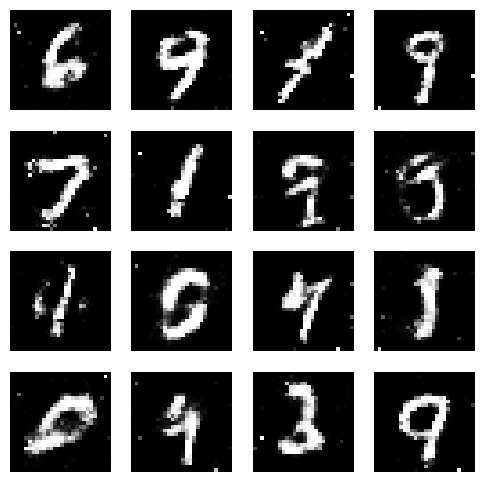

In [ ]:
# 6. Visualizing Generated Digits
import matplotlib.pyplot as plt

z = torch.randn(16, 100).to(device)
samples = generator(z).cpu().detach()

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for ax, img in zip(axes.flatten(), samples):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
plt.show()